In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = False

In [117]:
# Import pyMC3 and also arviz for visualisation
import pymc3 as pm
import arviz as az
# Import the other core data science packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn import datasets
from scipy.stats import norm
import statsmodels.formula.api as smf

RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
import seaborn as sns

## Data

In [175]:
# True parameter values
alpha_, sigma_ = 1, 0.3
beta_ = [1]

# Size of dataset
size = 20

data = pd.DataFrame()
# Predictor variable
data['x1'] = np.linspace(0,1,size)

# Simulate outcome variable
data['y'] = alpha_ + beta_[0] * data['x1']
data['y_measure'] = data['y'] + rng.normal(size=size) * sigma_

<Axes: xlabel='x1'>

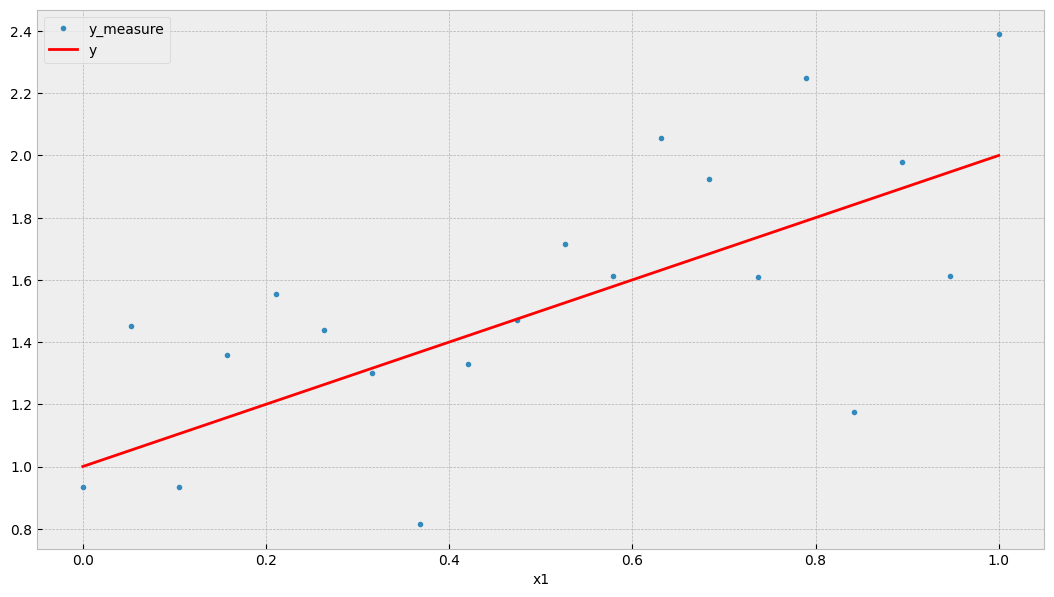

In [176]:
fig,ax=plt.subplots()
data.plot(x='x1', y='y_measure', style='.', ax=ax)
data.plot(x='x1', y='y', style='r-', ax=ax)

## OLS regression

In [177]:
# OLS line
formula = 'y_measure ~ x1'
results = smf.ols(formula, data=data).fit()

In [178]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              y_measure   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     15.10
Date:                Fri, 03 Mar 2023   Prob (F-statistic):            0.00108
Time:                        13:53:51   Log-Likelihood:                -4.6692
No. Observations:                  20   AIC:                             13.34
Df Residuals:                      18   BIC:                             15.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.0843      0.139      7.811      0.000       0.793       1.376
x1             0.9221      0.237      3.885      0.001       0.424       1.421
==============================================================================
Omnibus:                        1.845   Durbin-Watson:                   2.439
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.295
Skew:                          -0.611   Prob(JB):                        0.523
Kurtosis:                       2.755   Cond. No.                         4.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: xlabel='x1'>

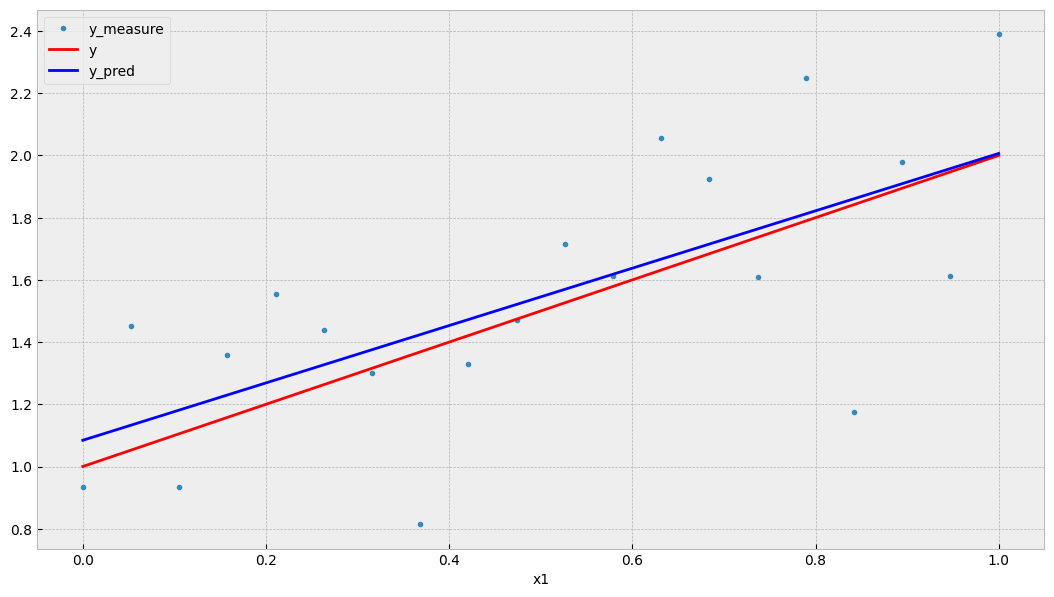

In [179]:
X = data[['x1']]
prediction = X.copy()
prediction['y_pred'] = results.predict(X)

fig,ax=plt.subplots(sharex=True)
data.plot(x='x1', y='y_measure', style='.', ax=ax)
data.plot(x='x1', y='y', style='r-', ax=ax)
prediction.plot(x='x1', y='y_pred', style='b-', ax=ax)

## Bayesian

In [190]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=alpha_, sigma=0.1)
    beta = pm.Normal("beta", mu=beta_, sigma=0.1, shape=1)
    sigma = pm.HalfNormal("sigma", sigma=sigma_)

    # Expected value of outcome
    mu = alpha + beta[0] * data['x1']

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=data['y_measure'])

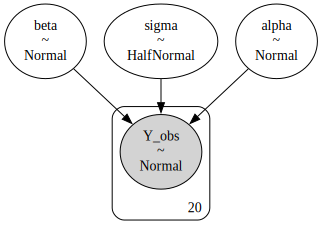

In [191]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'

pm.model_to_graphviz(basic_model)

In [192]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(draws=100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]


Sampling 2 chains for 1_000 tune and 100 draw iterations (2_000 + 200 draws total) took 19 seconds.


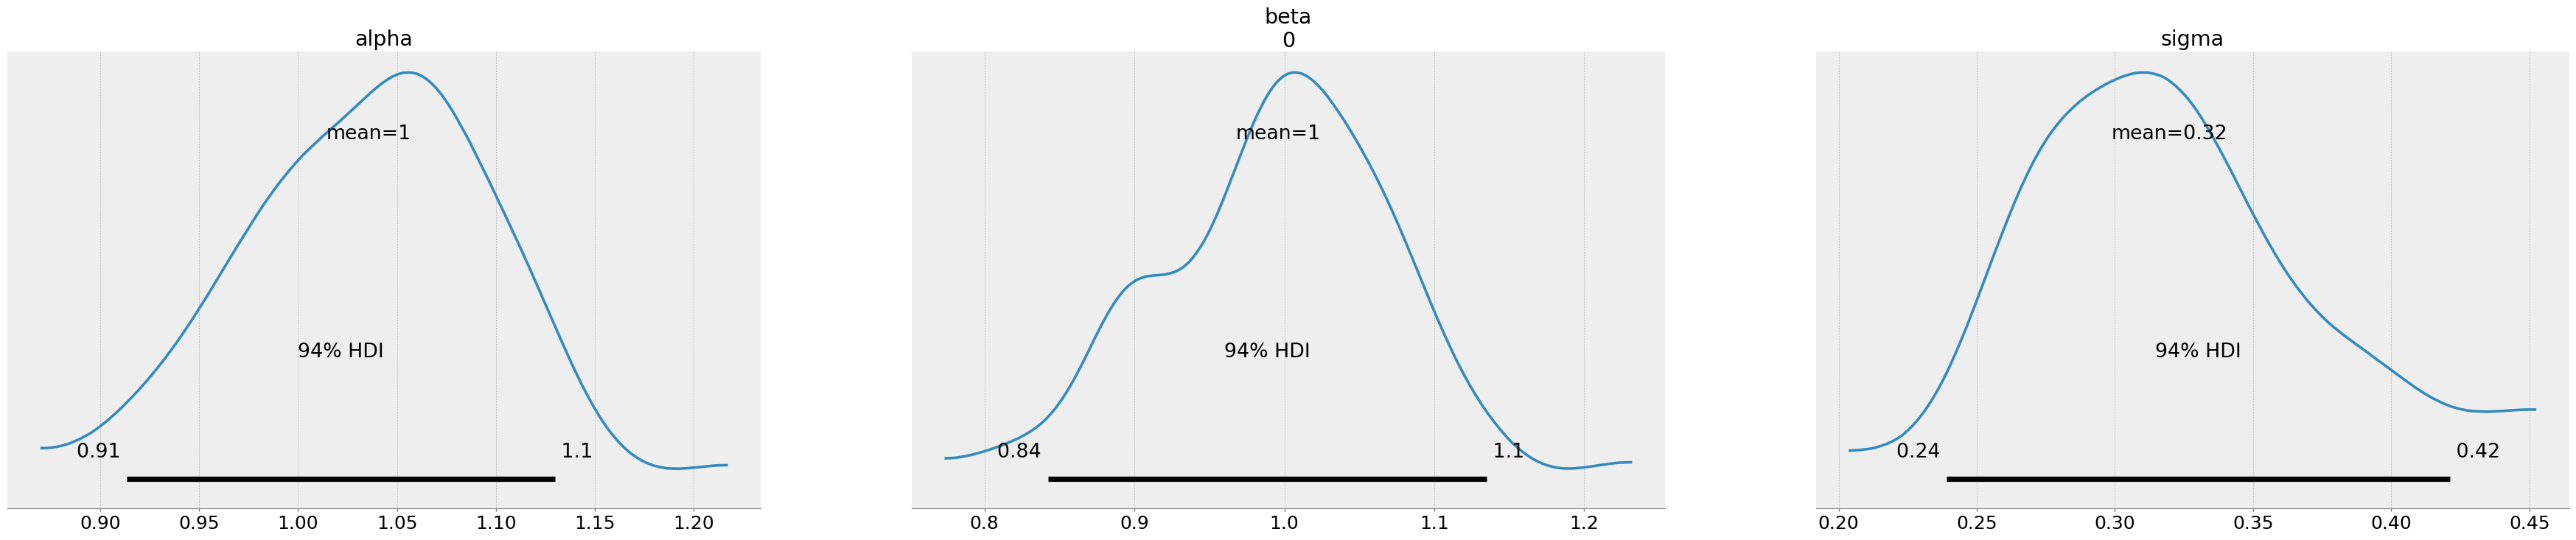

In [193]:
with basic_model:
    az.plot_posterior(idata,
                      var_names=['alpha', 'beta', 'sigma'],
                      textsize=18,
                      point_estimate='mean',
                      rope_color='black')

In [194]:
az.summary(idata)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.036,0.062,0.913,1.130,0.005,0.003,178.0,228.0,1.00
beta[0],0.996,0.080,0.842,1.135,0.006,0.004,162.0,130.0,1.04
sigma,0.320,0.050,0.239,0.421,0.004,0.003,150.0,156.0,1.00


In [195]:
with basic_model:   
    prior_samples = pm.sample_prior_predictive(samples=1000, var_names=["alpha", "beta"])

In [196]:
with basic_model:   
    y_test = pm.sample_posterior_predictive(idata, var_names=["alpha", "beta"], samples=1000)

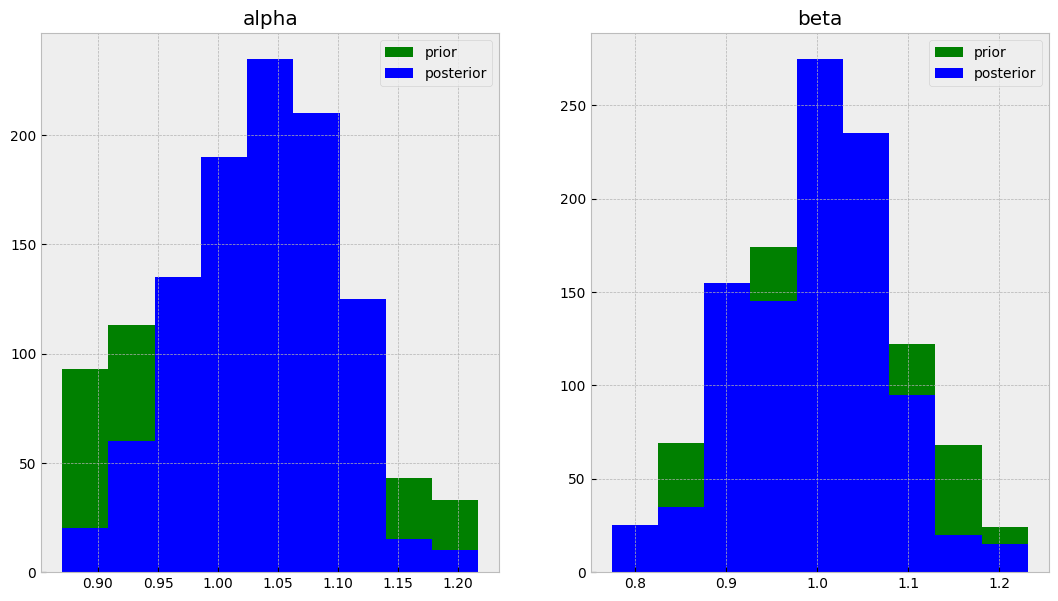

In [197]:
fig,axes=plt.subplots(ncols=2)
for (key, values),ax in zip(y_test.items(),axes.flatten()):
    bins = np.linspace(np.min(values),np.max(values),10)
    ax.hist(prior_samples[key],color='green', label='prior', bins=bins)
    ax.hist(values, color='blue', label='posterior', bins=bins)
    ax.set_title(key)
    ax.legend()

In [198]:
prediction['bayes'] = idata['alpha'].mean() + idata['beta'][0].mean()*data['x1']

<Axes: xlabel='x1'>

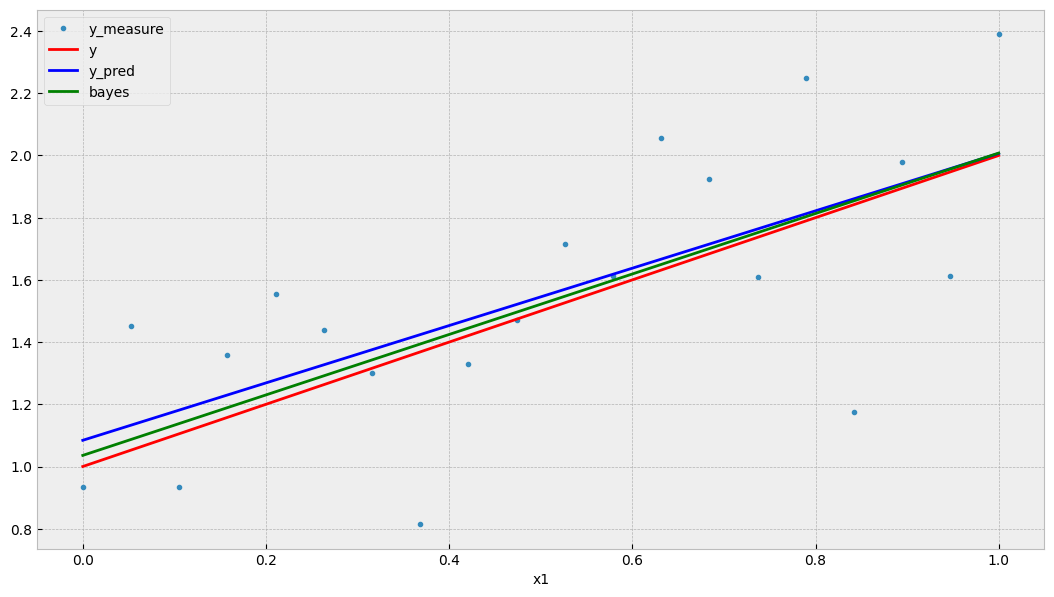

In [199]:
fig,ax=plt.subplots(ncols=1, sharex=True)
data.plot(x='x1', y='y_measure', style='.', ax=ax)
data.plot(x='x1', y='y', style='r-', ax=ax)
prediction.plot(x='x1', y='y_pred', style='b-', ax=ax)
prediction.plot(x='x1', y='bayes', style='g-', ax=ax)